<a href="https://colab.research.google.com/github/K-Hebel/WiDS_Chi/blob/master/Model_WiDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Libraries

In [191]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics 

In [194]:
#@title
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"khebel","key":"11c0f35aedbce6808a3f45f82709accf"}'}

In [195]:

#@title
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'widsdatathon2021'
! unzip TrainingWiDS2021.csv.zip -d train
! unzip UnlabeledWiDS2021.csv.zip -d train

mkdir: cannot create directory ‘/root/.kaggle’: File exists
UnlabeledWiDS2021.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
TrainingWiDS2021.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmissionWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
DataDictionaryWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
SolutionTemplateWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  TrainingWiDS2021.csv.zip
replace train/TrainingWiDS2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  UnlabeledWiDS2021.csv.zip
replace train/UnlabeledWiDS2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [196]:

df=pd.read_csv("train/TrainingWiDS2021.csv")

#Final Model Submitted for WiDS Datathon 2021
##Kaggle Acurracy Score= 0.84398
###Load Original DataFile of 130,157 records (Clean Based on Proportion of Available Data - df_B)

Our model was based on establishing a sample dataset that would be most free of bias and most balanced in its approach. In addition, given its potential for clinical usage, we intentionally sought to reduce the number of features within the model’s sample dataset. The sample was formulated by: 
 
1.   A random sampling of the population to produce equal amounts of diabetic and non-diabetic data;

2. Dropping features with more than 70% of the data missing (based on 56,302 total records);
3. Dropping features not directly related to patient care statistics (e.g. ids, stay types);     
4. Encoding ‘gender’ and ‘ethnicity’ data.

To account for missing data and avoid faulty imputation, we chose to use the XGBClassisifier model with hyperparameter tuning.   


In [197]:
#@title
df_B=pd.read_csv("train/TrainingWiDS2021.csv")



##Create Stratified Sample of df_B dataset to balance target variable value counts for sample size of 56,302 (included all positive diabetes_mellitus from original dataset)

In [198]:
df_B['diabetes_mellitus'].value_counts()

0    102006
1     28151
Name: diabetes_mellitus, dtype: int64

In [199]:
df_B=df_B.groupby(['diabetes_mellitus'], group_keys=False).apply(lambda x: x.sample(28151, random_state=40))
df_B.describe()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,56302.000000,56302.000000,56302.000000,54522.000000,54395.000000,56302.000000,55478.000000,56302.000000,56302.000000,56302.0,54823.000000,22826.000000,55686.000000,56040.000000,56302.000000,56302.000000,20776.000000,45842.000000,46073.000000,13385.000000,55464.000000,55464.000000,56064.000000,55464.000000,51503.000000,56191.000000,44803.000000,56302.000000,56145.000000,13385.000000,13385.000000,13385.000000,13385.000000,55964.000000,46232.000000,53504.000000,28215.000000,56302.000000,43696.000000,15379.000000,...,12121.000000,12121.000000,12027.000000,12027.000000,21198.000000,21198.000000,5262.000000,5262.000000,10837.000000,10837.000000,13552.000000,13552.000000,13066.000000,13066.000000,10718.000000,10718.000000,20212.000000,20212.000000,20072.000000,20072.000000,20420.000000,20420.000000,16302.000000,16302.000000,10079.000000,10079.000000,10000.000000,10000.000000,10186.000000,10186.000000,7522.000000,7522.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000
mean,64655.550886,212782.740631,105.763952,62.966802,30.088126,0.189194,169.589446,659.607634,0.880027,0.0,86.536353,2.871011,185.567486,561.430807,0.204558,0.040798,1.148028,27.796896,1.611887,0.590217,3.501154,5.503263,0.010702,4.050898,182.272648,99.565482,32.697951,0.156424,87.213227,42.329880,42.329880,128.974666,7.350237,25.008498,137.790517,36.413557,1818.065343,0.335636,12.197321,78.425190,...,11.102698,10.978591,33.477592,33.082581,1.595339,1.478905,3.022566,2.971556,196.161392,195.331549,4.234279,4.193200,137.989354,137.713746,13.425110,13.371630,45.464702,38.629215,7.385845,7.319480,163.004663,101.419519,287.060059,223.108487,44.689945,43.413494,7.335085,7.324899,161.350738,143.608198,245.075033,236.977194,0.000817,0.017655,0.014547,0.025949,0.007211,0.004387,0.019609,0.500000
std,37322.197747,38119.387311,63.894105,15.957276,8.632753,0.391666,10.821274,302.351038,2.543398,0.0,25.897005,0.675654,86.330833,461.686481,0.403382,0.197823,2.241411,21.660958,1.653390,0.262116,0.927126,1.249989,0.102897,1.525480,103.282847,30.313777,6.730786,0.363260,42.099895,12.515119,12.515119,82.140011,0.098808,15.061278,5.306175,0.860963,1468.719663,0.472217,6.829036,21.695247,...,2.301571,2.335979,6.648873,6.817623,0.970976,0.753246,2.880175,2.840215,92.882939,93.053916,0.779588,0.771397,5.673122,5.606040,6.863777,6.853997,14.795767,11.208354,0.086445,0.111693,105.064639,59.696393,130.029869,119.051158,14.907696,14.344309,0.107067,0.109611,110.571850,98.442800,131.813594,128.627077,0.028572,0.131694,0.119730,0.158986,0.084612,0.066090,0.138652,0.500004
min,1.000000,147001.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.237500,0.0,38.600000,1.200000,101.00

In [200]:
df_B['diabetes_mellitus'].value_counts()

1    28151
0    28151
Name: diabetes_mellitus, dtype: int64

##Proportion of Missing Data in df_B by Feature Column and Count of Available data by Feature Column

In [201]:
missing_data_B= pd.DataFrame(df_B.isna().sum()/df_B['diabetes_mellitus'].count())
missing_data_B['Available']= df_B.notna().sum()
missing_data_B.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_min,0.918173,4607
h1_bilirubin_max,0.918173,4607
h1_albumin_max,0.910696,5028
h1_albumin_min,0.910696,5028
h1_lactate_min,0.906540,5262
...,...,...
icu_stay_type,0.000000,56302
icu_id,0.000000,56302
elective_surgery,0.000000,56302
hospital_id,0.000000,56302


##Drop Columns with missing data >=70% from df_B

In [202]:
col_drop=missing_data_B[missing_data_B[0]>= 0.70].sort_values(by=0, ascending=False)
df_B= df_B.drop(list(col_drop.index), axis=1) #[0].sort_values
df_B.shape

(56302, 126)

##Drop Features Not Associated with Patient Vitals

In [203]:
drop_cols2 =['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'elective_surgery',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 ]

df_B2=df_B.drop(drop_cols2, axis=1)
df_B2.shape

(56302, 115)

##Encode Categorical Data in sample_df_B2 (Sample set of df_B)

In [204]:
df_B2.select_dtypes(include=['object']).columns

Index(['ethnicity', 'gender'], dtype='object')

In [205]:

df_B3=df_B2.drop(['gender','ethnicity'], axis=1)
df_B3.shape

(56302, 113)

##Set Features and Target (sample of df_B) & Training, Test Split

In [206]:
y_b=df_B3['diabetes_mellitus']
X_b=df_B3.drop(['diabetes_mellitus'], axis=1)

X_b_train, X_b_test, y_b_train,y_b_test =train_test_split(X_b,y_b, random_state=40)

In [207]:
y_b_train.shape, X_b_train.shape

((42226,), (42226, 112))

In [208]:
y_b_test.shape, X_b_test.shape

((14076,), (14076, 112))

##Create Training and Predictive Models For df_B (Sample set of 56,302)

In [209]:
model_1_B= XGBClassifier(booster='dart', max_depth=3, n_estimators=300, n_jobs=2, random_state=40, importance_type="weight") #used to manage datasets with missing values

## XGBClassifier Model 1 - df_B

In [210]:
model_1_B.fit(X_b_train,y_b_train)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=40,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [211]:

model_1_B.score(X_b_test,y_b_test)

0.7747229326513214

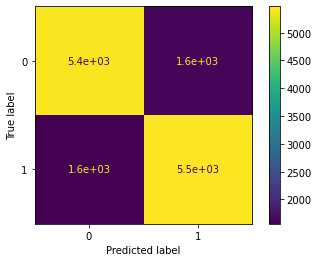

In [257]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_1_B, X_b_test, y_b_test)  
plt.show()

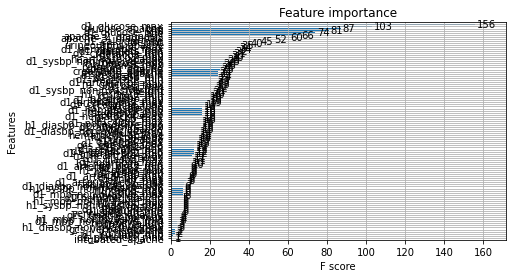

In [212]:
from xgboost import plot_importance
plot_importance(model_1_B)
plt.show()

##Predictions based on model_B XGBClassifier

In [213]:
test_df_B=pd.read_csv('train/UnlabeledWiDS2021.csv')

In [214]:
test_col_B=list(X_b.columns)


In [215]:
test_df_B['diabetes_mellitus']=model_1_B.predict_proba(test_df_B[test_col_B])[:,1]
submit_B = test_df_B[['encounter_id','diabetes_mellitus']]
submit_B

,encounter_id,diabetes_mellitus
0,144740,0.161971
1,141990,0.431168
2,142038,0.420837
3,138628,0.177768
4,141682,0.579420
...,...,...
10229,143750,0.169106
10230,143813,0.325099
10231,137126,0.387309
10232,135652,0.058531


In [216]:
test_df_B['diabetes_mellitus'].sum()

3997.5369

In [217]:
submit_B.to_csv('Boost_Class_B.csv',index=False)

#Alternative Model - Model_A
##Kaggle Accuracy Score= 0.82124
###Reduce data Set to 50,000 record sample of orginal training dataset (Cleaned Based on EDA comments -df_A)

Sample to balance ethnicity and use replace to fill rows

In [218]:
df.ethnicity.value_counts()

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64

In [219]:
df_A=df.groupby('ethnicity', group_keys=False).apply(lambda x: x.sample(1000, replace=True))

In [220]:
df_A.ethnicity.value_counts()

Caucasian           1000
Native American     1000
Other/Unknown       1000
Asian               1000
Hispanic            1000
African American    1000
Name: ethnicity, dtype: int64

Sample of sample to balance target variable values

In [221]:
df_A['diabetes_mellitus'].value_counts()

0    4455
1    1545
Name: diabetes_mellitus, dtype: int64

In [222]:
df_A=df.groupby('diabetes_mellitus', group_keys=False).apply(lambda x: x.sample(2000, replace=True, random_state=40))

In [223]:
df_A['diabetes_mellitus'].value_counts()

1    2000
0    2000
Name: diabetes_mellitus, dtype: int64

## Initial Categories to Drop Based on Being Patient Vitals Agnostic

In [224]:
drop_cat=['Unnamed: 0'	,'encounter_id','hospital_id','elective_surgery','icu_id',	'pre_icu_los_days',	'readmission_status',\
          'hospital_admit_source',	'icu_admit_source',	'icu_stay_type',	'icu_type']

df_A=df_A.drop(drop_cat, axis=1)

In [225]:
df_A.shape

(4000, 170)

##Calculate BMI and replace 'height' and 'weight' columns

In [226]:
df_A['bmi']= df_A['weight']/((df_A['height']/100)**2)

In [227]:
df_A_2=df_A.drop(['height', 'weight', 'gender','ethnicity'], axis = 1)

##Proportion of Missing Data in df_A by Feature Column and Count of Available data by Feature Column

In [228]:
missing_data= pd.DataFrame(df_A_2.isna().sum()/df_A_2['diabetes_mellitus'].count())
missing_data['Available']= df_A_2.notna().sum()
missing_data.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_max,0.92225,311
h1_bilirubin_min,0.92225,311
h1_albumin_min,0.91375,345
h1_albumin_max,0.91375,345
h1_lactate_min,0.91100,356
...,...,...
d1_sysbp_min,0.00000,4000
intubated_apache,0.00000,4000
apache_post_operative,0.00000,4000
arf_apache,0.00000,4000


## Drop Features where total available data is less than 20% of data set

In [229]:
features_under_20per =[]

for col in list(df_A_2.columns):
  if df_A_2[col].count()/df_A_2.count()[-1]< .2:
    features_under_20per.append(col)

In [230]:
df_A_3 = df_A_2.drop(features_under_20per, axis=1)

In [231]:
df_A_3.shape

(4000, 144)

##Set Features and Target (df_A) and Train_Test_split

In [232]:
y_a=df_A_3['diabetes_mellitus']
X_a=df_A_3.drop(['diabetes_mellitus'], axis=1)

X_a_train, X_a_test,y_a_train, y_a_test =train_test_split(X_a,y_a, random_state=40)

In [233]:
y_a.shape, X_a.shape

((4000,), (4000, 143))

In [234]:
y_a_train.shape, X_a_train.shape

((3000,), (3000, 143))

##Create Training and Predictive Models For df_A (Sample set of 50,000)

In [235]:
model_1_A= XGBClassifier(booster='dart', max_depth=3, n_estimators=300, n_jobs=3, random_state=40) #used to manage datasets with missing values

## XGBClassifier Model 1 - df_A

In [236]:
model_1_A.fit(X_a_train,y_a_train)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=3,
              nthread=None, objective='binary:logistic', random_state=40,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [237]:
model_1_A.score(X_a_test,y_a_test)

0.736

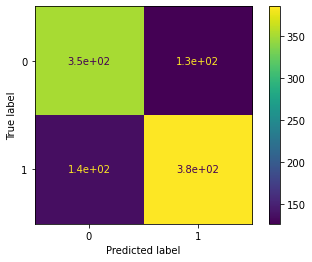

In [258]:
plot_confusion_matrix(model_1_A, X_a_test, y_a_test)  
plt.show()

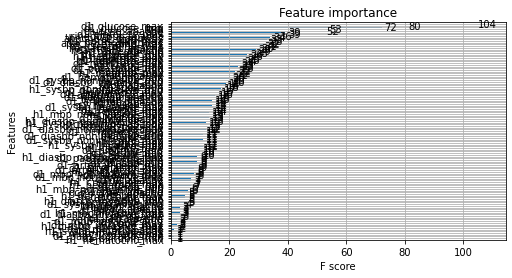

In [238]:
plot_importance(model_1_A)
plt.show()

##Predictions based on model_A XGBClassifier

In [239]:
test_df_A=pd.read_csv('train/UnlabeledWiDS2021.csv')

In [240]:
test_col_A=list(X_a.columns)

In [241]:
test_df_A['diabetes_mellitus']=model_1_A.predict_proba(test_df_A[test_col_A]) [:,1]
submit_A = test_df_A[['encounter_id','diabetes_mellitus']]
submit_A

,encounter_id,diabetes_mellitus
0,144740,0.319310
1,141990,0.342009
2,142038,0.391538
3,138628,0.105751
4,141682,0.870084
...,...,...
10229,143750,0.167511
10230,143813,0.341109
10231,137126,0.649254
10232,135652,0.023002


In [242]:
test_df_A['diabetes_mellitus01']=model_1_A.predict(test_df_A[test_col_A])
submit_0 = test_df_A[['encounter_id','diabetes_mellitus','diabetes_mellitus01']]
submit_0

,encounter_id,diabetes_mellitus,diabetes_mellitus01
0,144740,0.319310,0
1,141990,0.342009,0
2,142038,0.391538,0
3,138628,0.105751,0
4,141682,0.870084,1
...,...,...,...
10229,143750,0.167511,0
10230,143813,0.341109,0
10231,137126,0.649254,1
10232,135652,0.023002,0


In [243]:
test_df_A['diabetes_mellitus'].sum()

3984.7769

In [244]:
submit_A.to_csv('Boost_Class_A.csv',index=False)

#Alternative Model_C
##Kaggle Accuracy Score= 0.69186   
###3rd Smaller and more balanced sample set


In [245]:
my_samp=pd.read_csv('/content/drive/My Drive/my_sample.csv')

In [246]:
y_s=my_samp['diabetes_mellitus']
X_s=my_samp.drop(['diabetes_mellitus'], axis=1)

X_s_train, X_s_test, y_s_train,y_s_test =train_test_split(X_s,y_s, random_state=40)

In [247]:
X_s_train.shape

(23157, 65)

In [248]:
model_3= XGBClassifier(booster='dart', max_depth=3, n_estimators=300, n_jobs=2, random_state=40, importance_type="weight") #used to manage datasets with missing values

In [249]:
model_3.fit(X_s_train,y_s_train)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=40,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [250]:
model_3.score(X_s_test,y_s_test)

0.9104806322062443

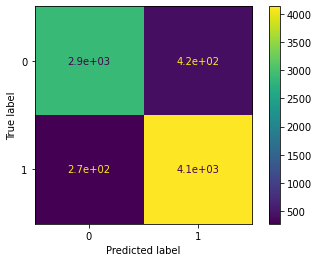

In [259]:
plot_confusion_matrix(model_3, X_s_test, y_s_test)  
plt.show()

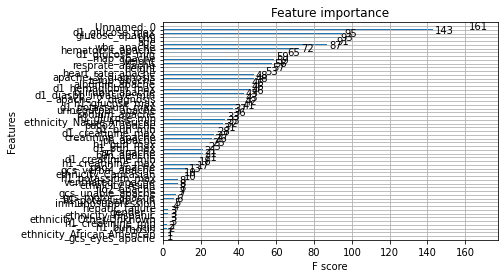

In [256]:
plot_importance(model_3)
plt.show()

In [251]:
test_samp=pd.read_csv('train/UnlabeledWiDS2021.csv')

In [252]:
samp_encode=pd.get_dummies(test_samp[['ethnicity','gender']])
test_samp=test_samp.join(samp_encode)

In [253]:
test_col_samp=list(X_s.columns)

In [254]:
test_samp['diabetes_mellitus']=model_3.predict_proba(test_samp[test_col_samp])[:,1]
submit_samp = test_samp[['encounter_id','diabetes_mellitus']]
submit_samp

,encounter_id,diabetes_mellitus
0,144740,0.855997
1,141990,0.814279
2,142038,0.813597
3,138628,0.677599
4,141682,0.936660
...,...,...
10229,143750,0.696279
10230,143813,0.619401
10231,137126,0.707040
10232,135652,0.558066


In [255]:
submit_samp.to_csv('Boost_Class_C.csv',index=False)